In [1]:
from torch import nn
import torch
import pandas as pd
import numpy as np
import os
from torchvision.io import read_image
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import transforms3d as tf
from vit_pytorch import ViT

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mc = 350 # 345 is max dim, of binned event image
bins = 1
delta = 10 # corresponding to running loc at 10Hz

class EventDataset(Dataset):
    def __init__(self, data_dir, label_delta_len):
        events_cols=["timestamp", "x", "y", "polarity"]
        events_df = pd.read_csv(os.path.join(data_dir,"events.txt"), delimiter=' ', skiprows=1, names=events_cols)
        events_df_nostamp = events_df.loc[:, events_df.columns != 'timestamp']
        self.events_data = torch.from_numpy(events_df_nostamp.to_numpy(dtype=np.float32)).type(torch.LongTensor)

        indexed_labels_pickle = f"event_indexed_labels_{delta}.pickle"
        if os.path.isfile(indexed_labels_pickle):
            self.labels_df = pd.read_pickle(indexed_labels_pickle)
        else:
            label_cols = ["timestamp","tx","ty","tz","qx","qy","qz","qw","none"]
            labels_df = pd.read_csv(os.path.join(data_dir,"groundtruth.txt"), delimiter=' ', skiprows=1, names=label_cols)
            labels_df = labels_df.iloc[: , :-1]
            labels_df["events_start_idx"] = 0
            self.labels_df = labels_df
            labels_df_nostamp = labels_df.loc[:, labels_df.columns != 'timestamp']
            labels_df_nostamp = labels_df_nostamp.loc[:, labels_df_nostamp.columns != 'events_start_idx']
            labels = labels_df_nostamp.to_numpy()

            new_cols = ["dtx","dty","dtz","dqw","dqx","dqy","dqz"]
            for col in new_cols:
                self.labels_df[col] = 0.0
            first_id = abs(events_df["timestamp"]-self.labels_df.iloc[0]["timestamp"]).idxmin()
            for i in range(len(self.labels_df)-delta):
                label_ts = self.labels_df.iloc[i,0]
                # hopefully no more than 10k event between labels
                id = events_df[first_id:first_id+int(1e4)]["timestamp"].sub(label_ts).abs().idxmin()
                self.labels_df["events_start_idx"][i] = id
                first_id = id
                if i % 1000 == 0:
                    print(i)

                dpose = np.zeros(7, dtype=np.float64)
                l1 = labels[i]
                l2 = labels[i+delta]
                dl = l2-l1 # position delta
                dpose[:3] = dl[:3]
                q1 = l1[3:][[3,0,1,2]] # rearange quaternion, w goes first
                q2 = l2[3:][[3,0,1,2]] # rearange quaternion, w goes first
                dq = tf.quaternions.qmult(q2, tf.quaternions.qinverse(q1)) # orientation delta
                dpose[3:] = dq # pose delta is the label

                for col_index,col in enumerate(new_cols):
                    self.labels_df[col][i+delta] = dpose[col_index]
                
            # save for easy loading
            self.labels_df.to_pickle(indexed_labels_pickle)

        self.labels = torch.tensor(self.labels_df.loc[:, 'dtx':'dqz'].to_numpy(), dtype=torch.float32)

        self.delta = label_delta_len

    def __len__(self):
        return self.labels.shape[0] - self.delta

    def __getitem__(self, idx):
        dpose = self.labels[idx+self.delta]

        start = self.labels_df.iloc[idx]["events_start_idx"]
        finish = self.labels_df.iloc[idx+self.delta]["events_start_idx"]

        if bins > 1:
            num_per_bin = int((finish-start)/bins)
            binned_events = torch.zeros((bins,mc,mc))
            for b in range(bins):
                start_bin = int(start)+b*num_per_bin
                if b != (bins - 1):
                    events = self.events_data[start_bin:start_bin+num_per_bin]
                else:
                    events = self.events_data[start_bin:int(finish)]
                binned_events[b] = torch.index_put(binned_events[b], (events[:,1], events[:,0]), (events[:,2].type(torch.FloatTensor) - .5), accumulate=True)
        else:
            binned_events = torch.zeros((bins,mc,mc))
            events = self.events_data[int(start):int(finish)]
            binned_events[0] = torch.index_put(binned_events[0], (events[:,1], events[:,0]), (events[:,2].type(torch.FloatTensor) - .5), accumulate=True)

        return binned_events, dpose

    def set_label_delta(self, delta):
        self.delta = delta

data_dir = "indoor_forward_9_davis_with_gt"
vio_dataset = EventDataset(data_dir, delta)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


(tensor(2.), tensor(-2.), torch.Size([350, 350]), tensor(0.))

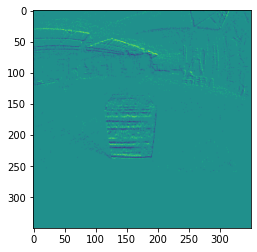

In [3]:
vio_dataset.set_label_delta(delta)
point = vio_dataset.__getitem__(1500)
events = point[0].squeeze(0)
for i in range(bins):
    plt.figure(i)
    if bins == 1:
        plt.imshow(events)
    else:
        plt.imshow(events[i])
events.max(), events.min(), events.shape, torch.norm(1 - torch.norm(point[1][3:]))

In [4]:
import time
s = time.time()
for i in range(len(vio_dataset)):
    size = vio_dataset.__getitem__(i)[0].shape[0]
(time.time() - s) / 1000 # per one sample, very quick

0.006513697862625122

In [5]:
model = ViT(
    image_size = 350,
    patch_size = 25,
    num_classes = 7,
    dim = 32,
    depth = 6,
    heads = 8,
    mlp_dim = 64,
    dropout = 0.1,
    emb_dropout = 0.0,
    channels=bins
)

img = vio_dataset.__getitem__(1002)[0].unsqueeze(0) # batch 1
preds = model(img) # (1, 7)
preds

tensor([[ 0.4335, -0.1943,  0.2204,  0.0431, -0.6796,  0.0478,  0.0444]],
       grad_fn=<AddmmBackward0>)

In [6]:
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,30,45,65], gamma=1.0)
dataloader = torch.utils.data.DataLoader(vio_dataset, batch_size=128, shuffle=True, num_workers=4)
next(iter(dataloader))[0].shape

torch.Size([128, 1, 350, 350])

In [7]:
# # ### lr search : )
# lr = .01
# gamma = .5
# [lr*gamma**x for x in range(10)]

In [8]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html training loop from here

torch.cuda.empty_cache()

num_epochs = 75
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels) # + torch.norm(1 - torch.norm(outputs[3:]), 1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(vio_dataset)

        print(f'{phase} Loss: {epoch_loss:.8f}')
        scheduler.step()

Epoch 0/74
----------
train Loss: 0.03131873
Epoch 1/74
----------
train Loss: 0.00505527
Epoch 2/74
----------
train Loss: 0.00417489
Epoch 3/74
----------
train Loss: 0.00402091
Epoch 4/74
----------
train Loss: 0.00396740
Epoch 5/74
----------
train Loss: 0.00364881
Epoch 6/74
----------
train Loss: 0.00328355
Epoch 7/74
----------
train Loss: 0.00303983
Epoch 8/74
----------
train Loss: 0.00321429
Epoch 9/74
----------
train Loss: 0.00210530
Epoch 10/74
----------
train Loss: 0.00188097
Epoch 11/74
----------
train Loss: 0.00149348
Epoch 12/74
----------
train Loss: 0.00127611
Epoch 13/74
----------
train Loss: 0.00134051
Epoch 14/74
----------
train Loss: 0.00115924
Epoch 15/74
----------
train Loss: 0.00080848
Epoch 16/74
----------
train Loss: 0.00099463
Epoch 17/74
----------
train Loss: 0.00086511
Epoch 18/74
----------
train Loss: 0.00073343
Epoch 19/74
----------
train Loss: 0.00059513
Epoch 20/74
----------
train Loss: 0.00060812
Epoch 21/74
----------
train Loss: 0.0006223

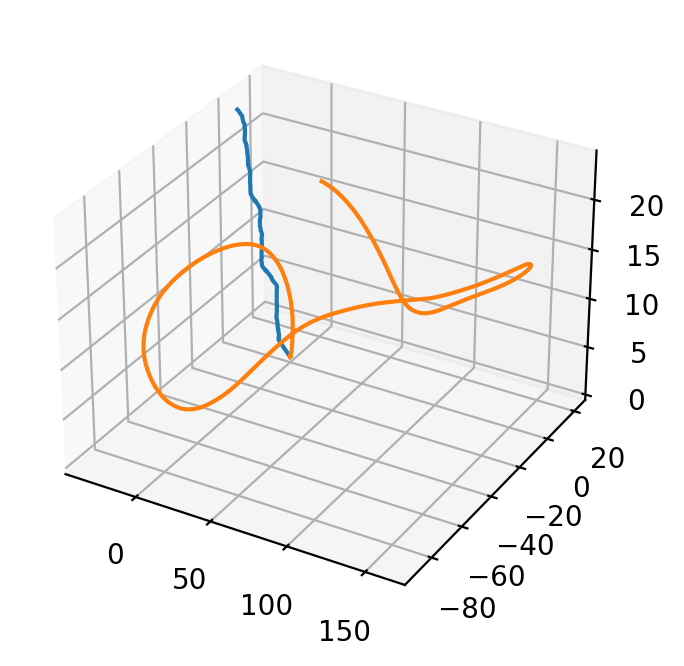

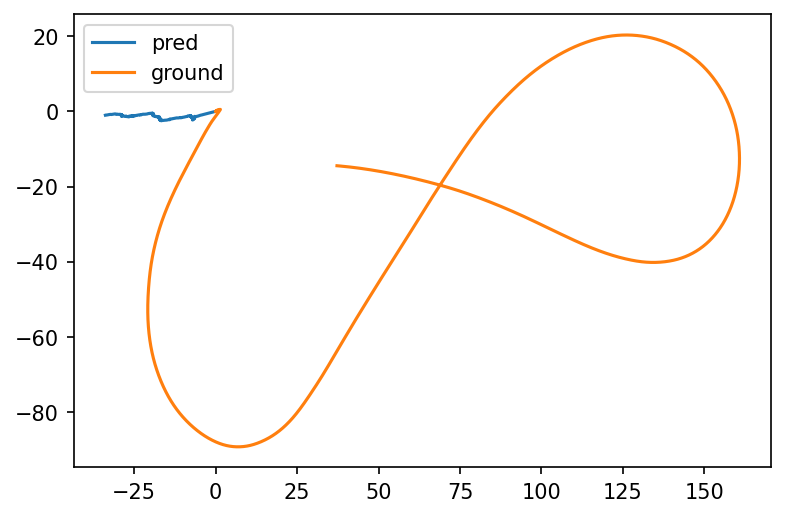

In [10]:
model.eval()
path = []
ground = []
x = np.zeros((3,1))
gtx = np.zeros((3,1))
for i in range(1500, int(len(vio_dataset)/2)):
    data_point = vio_dataset.__getitem__(i)
    delta_label = data_point[1].numpy().reshape(7,1)[:3]
    gtx += delta_label
    ground.append(gtx.copy())
    inputs = data_point[0].unsqueeze(0).to(device)
    outputs = model(inputs)
    dx = outputs.cpu().detach().numpy().T[:3]
    x += dx
    path.append(x.copy())
path = np.array(path).reshape(-1,3)
ground = np.array(ground).reshape(-1,3)
fig = plt.figure(dpi=200)
ax = plt.axes(projection='3d')
ax.plot3D(path[:,0],path[:,1],path[:,2])
ax.plot3D(ground[:,0],ground[:,1],ground[:,2])

plt.figure(2, dpi=150)
plt.plot(path[:,0],path[:,1])
plt.plot(ground[:,0],ground[:,1])
plt.legend(["pred","ground"])